## Data visualisations and exploratory data analysis of GCMC data

In [1]:
import os                     
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
import math 

# Get paths to data 
pwd = os.path.abspath(os.getcwd())           # present working directory 
results_dir = os.path.join(pwd,'GCMC_data')  # store of GCMC data for each material

%matplotlib inline

### Load in the material data

In [2]:
## Structural data from our subset of 726 materials
structural_data = pd.read_csv(os.path.join(pwd,'structural_data.csv'))
structural_data.head()

,Name,LCD,PLD,LFPD,cm3_g,ASA_A2,ASA_m2_cm3,ASA_m2_g,NASA_A2,NASA_m2_cm3,NASA_m2_g,AV_A3,AV_VF,AV_cm3_g,NAV_A3,NAV_VF,NAV_cm3_g,OMS,chemical_formula,total_atoms
0,ABUWOJ,5.07969,4.03039,4.98773,1.15833,781.908,1730.59,1494.040,0.0000,0.000,0.000,205.1240,0.0454,0.039195,0.00000,0.000,0.000000,8.0,Zn16H56C96O56,224
1,ACOLIP,4.91034,3.57647,4.78103,1.04949,168.230,1101.08,1049.160,0.0000,0.000,0.000,40.0299,0.0262,0.024965,0.00000,0.000,0.000000,0.0,Zn2H38C44N10O8,102
2,ACUBAB,6.47918,4.30437,6.24909,2.30944,198.675,1224.36,530.156,0.0000,0.000,0.000,102.5530,0.0632,0.027366,0.00000,0.000,0.000000,0.0,Zn16P12Cl2O48,78
3,AFITIT,7.35330,5.37116,7.35330,1.01683,592.260,1387.08,1364.110,0.0000,0.000,0.000,373.1850,0.0874,0.085953,0.00000,0.000,0.000000,0.0,Zn6H96C138N6O24,270
4,AFOQUI,4.25157,3.00568,4.24901,1.62091,0.000,0.00,0.000,60.9103,293.346,180.977,0.0000,0.0000,0.000000,8.30559,0.004,0.002468,4.0,Zn10H28C52N24O24,138


In [8]:
filename_data = []
for filename in os.listdir(results_dir):
    # get required information
    filename_data.append(filename.strip('.csv').split('_'))    

# get the unique material types
materials = [s[0] for s in filename_data]
unique_materials = list(set(materials))
inter = list(range(len(unique_materials)))
for_ranking = pd.DataFrame(list(zip(inter,unique_materials)),columns =['Number','Name'])

# Get list of materials which never meet the DoE constraints using any forcefield to generate the adsorption 
# data (CCS constraints: CO2 purity and recovery >= 0.9)
with open('neverDOE.txt','r') as file:
    f = file.readlines()
neverDOE = [s.split('\n')[0] for s in f]

# Get list of materials which were flagged as being structurally inconsistent (i.e., presence of unbound water 
# molecules, counter-ions and/or hydrogen atom with incorrect bond lengths/angles)
with open('structurally_inconsistent_MOFs.txt','r') as file:
    f = file.readlines()
badMOFs = [s.split('\n')[0] for s in f]


In [14]:
## Read in the GCMC isotherm simulated data
CO2_df = []
for name in unique_materials:
    material_file = os.path.join(results_dir,name+'_CO2.csv')
    df = pd.read_csv(material_file)
    df['Name'] = name
    CO2_df.append(df)
CO2_df = pd.concat(CO2_df,ignore_index=True)

N2_df = []
for name in unique_materials:
    material_file = os.path.join(results_dir,name+'_N2.csv')
    df = pd.read_csv(material_file)
    df['Name'] = name
    N2_df.append(df)
N2_df = pd.concat(N2_df,ignore_index=True)

Plot the distribution of uptakes in CRAFTED database

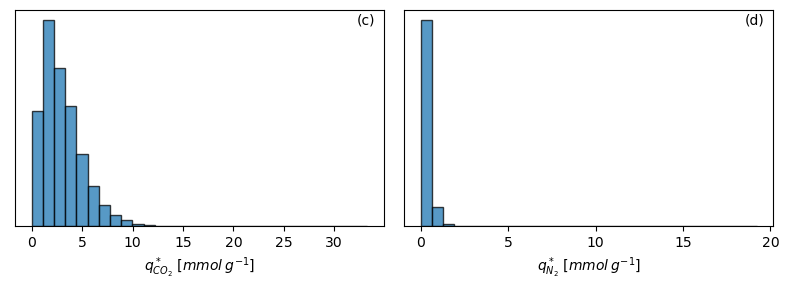

In [6]:
fig,ax = plt.subplots(1,2,figsize=(8,3),dpi=100)

n2 = N2_df[N2_df['Pressure(Pa)']==100000.0]; n2 = n2[n2['Temp(K)']==298];
co2 = CO2_df[CO2_df['Pressure(Pa)']==100000.0]; co2 = co2[co2['Temp(K)']==298]

# co2
ax[0].hist(co2['Loading(mmol/g)'],bins=30,alpha=0.75,edgecolor='black')
ax[0].set(xlabel='$q_{CO_2}^*\ [mmol \: g^{-1}$]',yticks=[])
ax[0].text(0.95, 0.95,'(c)', ha='center', va='center', transform=ax[0].transAxes)

ax[1].hist(n2['Loading(mmol/g)'],bins=30,alpha=0.75,edgecolor='black')
ax[1].set(xlabel='$q_{N_2}^*\ [mmol \: g^{-1}$]',yticks=[])
ax[1].text(0.95, 0.95,'(d)', ha='center', va='center', transform=ax[1].transAxes)

fig.tight_layout()
# plt.savefig('//nask.man.ac.uk/home$/Desktop/UQ_Project/Publications/Publication_2/Figures/SI_CRAFTED_distributions_pt2.png', dpi=500)


## Explore Correlations between MOFs and choice of ForceField

In [7]:
def get_R2(data,T,P,FFs):
    """Get R2 (coefficient of determination) between x data and y data

    Args:
        data (pandas dataframe): full CO2_df or full N2_df passed in (i.e. CO2 data for all materials, pressures, and temperatures)
        T (int): Temperature (273, 298, 323)
        P (float): Pressure value (i.e. 100.0, 200.0, 500.0, 1000.0, 2000.0, 5000.0, . . . 100000.0) Pa
        FFs (int): Forcefield ID number (between 1 - 8, see markdown cell at beginning of notebook)
    """
    byP = data[data['Pressure(Pa)']==P]
    byT = byP[byP['Temp(K)']==T]
    
    y_data = []
    x_data = []
    for j in range(len(FFs)):
        y_data.append(byT[byT['ID']==FFs[j][1]])
        x_data.append(byT[byT['ID']==FFs[j][0]])
    
    y = pd.concat(y_data, ignore_index=True)
    x = pd.concat(x_data, ignore_index=True)
    return r2_score(x['Loading(mmol/g)'],y['Loading(mmol/g)'])

def get_spearmanr(data,T,P,FFs):
    """Get spearman coefficient between x data and y data

    Args:
        data (pandas dataframe): full CO2_df or full N2_df passed in (i.e. CO2 data for all materials, pressures, and temperatures)
        T (int): Temperature (273, 298, 323)
        P (float): Pressure value (i.e. 100.0, 200.0, 500.0, 1000.0, 2000.0, 5000.0, . . . 100000.0) Pa
        FFs (int): Forcefield ID number (between 1 - 8, see markdown cell at beginning of notebook)
    """
    byP = data[data['Pressure(Pa)']==P]
    byT = byP[byP['Temp(K)']==T]
    
    y_data = byT[byT['ID']==FFs[0][1]]; sort_y = y_data.sort_values(by='Loading(mmol/g)',ascending=False)
    x_data = byT[byT['ID']==FFs[0][0]]; sort_x = x_data.sort_values(by='Loading(mmol/g)',ascending=False)
    
    # provide ordinal values to data
    rank_y = pd.DataFrame(sort_y['Name'].values,columns=['Name']); rank_y['rank_y'] = list(range(1,len(sort_y)+1))
    rank_x = pd.DataFrame(sort_x['Name'].values,columns=['Name']); rank_x['rank_x'] = list(range(1,len(sort_y)+1))
    
    rankings = pd.merge(rank_x,rank_y,on='Name')
    coef, p = spearmanr(rankings['rank_x'], rankings['rank_y'])
    
    return coef

## Deviations as a function of material properties 

Plot fractional deviation in uptake as a function of PLD

C:\Users\x82753cc\AppData\Local\Temp/ipykernel_40732/2610269773.py:10: RuntimeWarning: invalid value encountered in true_divide
  ax[0].scatter(structural_data[structural_data['Name']==name]['AV_VF'],material_data[material_data['ID']==1]['Loading(mmol/g)'].values/material_data[material_data['ID']==5]['Loading(mmol/g)'].values,
C:\Users\x82753cc\AppData\Local\Temp/ipykernel_40732/2610269773.py:12: RuntimeWarning: invalid value encountered in true_divide
  ax[1].scatter(structural_data[structural_data['Name']==name]['AV_VF'],material_data[material_data['ID']==2]['Loading(mmol/g)'].values/material_data[material_data['ID']==6]['Loading(mmol/g)'].values,
C:\Users\x82753cc\AppData\Local\Temp/ipykernel_40732/2610269773.py:14: RuntimeWarning: invalid value encountered in true_divide
  ax[2].scatter(structural_data[structural_data['Name']==name]['AV_VF'],material_data[material_data['ID']==3]['Loading(mmol/g)'].values/material_data[material_data['ID']==7]['Loading(mmol/g)'].values,
C:\Users\x827

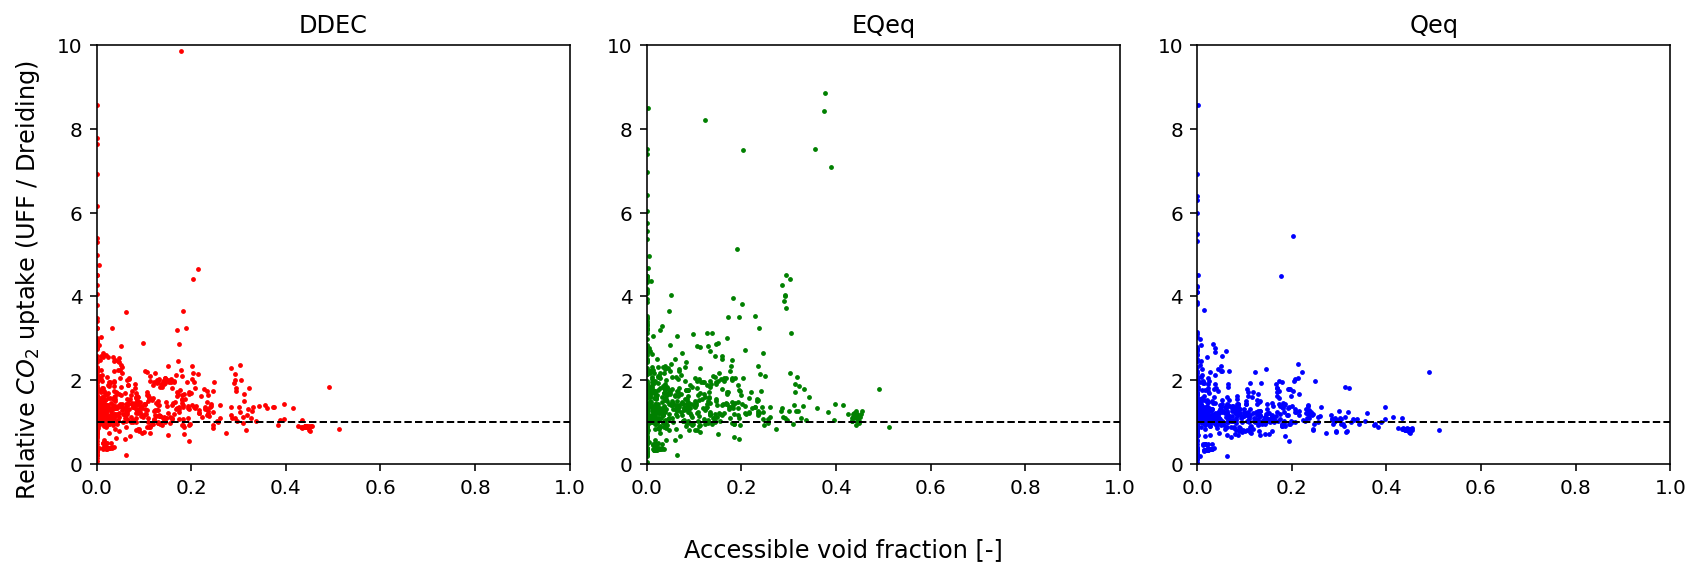

In [15]:
%config InlineBackend.figure_format = 'retina'

data_lowP_298K = CO2_df[CO2_df['Pressure(Pa)']==10000.0];data_lowP_298K = data_lowP_298K[data_lowP_298K['Temp(K)']==298]

f, ax=plt.subplots(1,3,figsize=(12,4))
f.supxlabel('Accessible void fraction [-]')
f.supylabel('Relative $CO_2$ uptake (UFF / Dreiding)')
for name in unique_materials:
    material_data = data_lowP_298K[data_lowP_298K['Name']==name]
    ax[0].scatter(structural_data[structural_data['Name']==name]['AV_VF'],material_data[material_data['ID']==1]['Loading(mmol/g)'].values/material_data[material_data['ID']==5]['Loading(mmol/g)'].values,
             s=2,color='r')
    ax[1].scatter(structural_data[structural_data['Name']==name]['AV_VF'],material_data[material_data['ID']==2]['Loading(mmol/g)'].values/material_data[material_data['ID']==6]['Loading(mmol/g)'].values,
         s=2,color='g')
    ax[2].scatter(structural_data[structural_data['Name']==name]['AV_VF'],material_data[material_data['ID']==3]['Loading(mmol/g)'].values/material_data[material_data['ID']==7]['Loading(mmol/g)'].values,
     s=2,color='b')
    
for i in range(3):
    ax[i].plot([0,25],[1,1],'--k',lw=1)
    ax[i].set_ylim(bottom=0,top=10)
    ax[i].set_xlim(left=0,right=1)
ax[0].set(title='DDEC')
ax[1].set(title='EQeq')
ax[2].set(title='Qeq')
f.tight_layout()
# plt.savefig('//nask.man.ac.uk/home$/Desktop/UQ_Project/Publications/Publication_2/Figures/AV_VF_deviation.png', dpi=500)


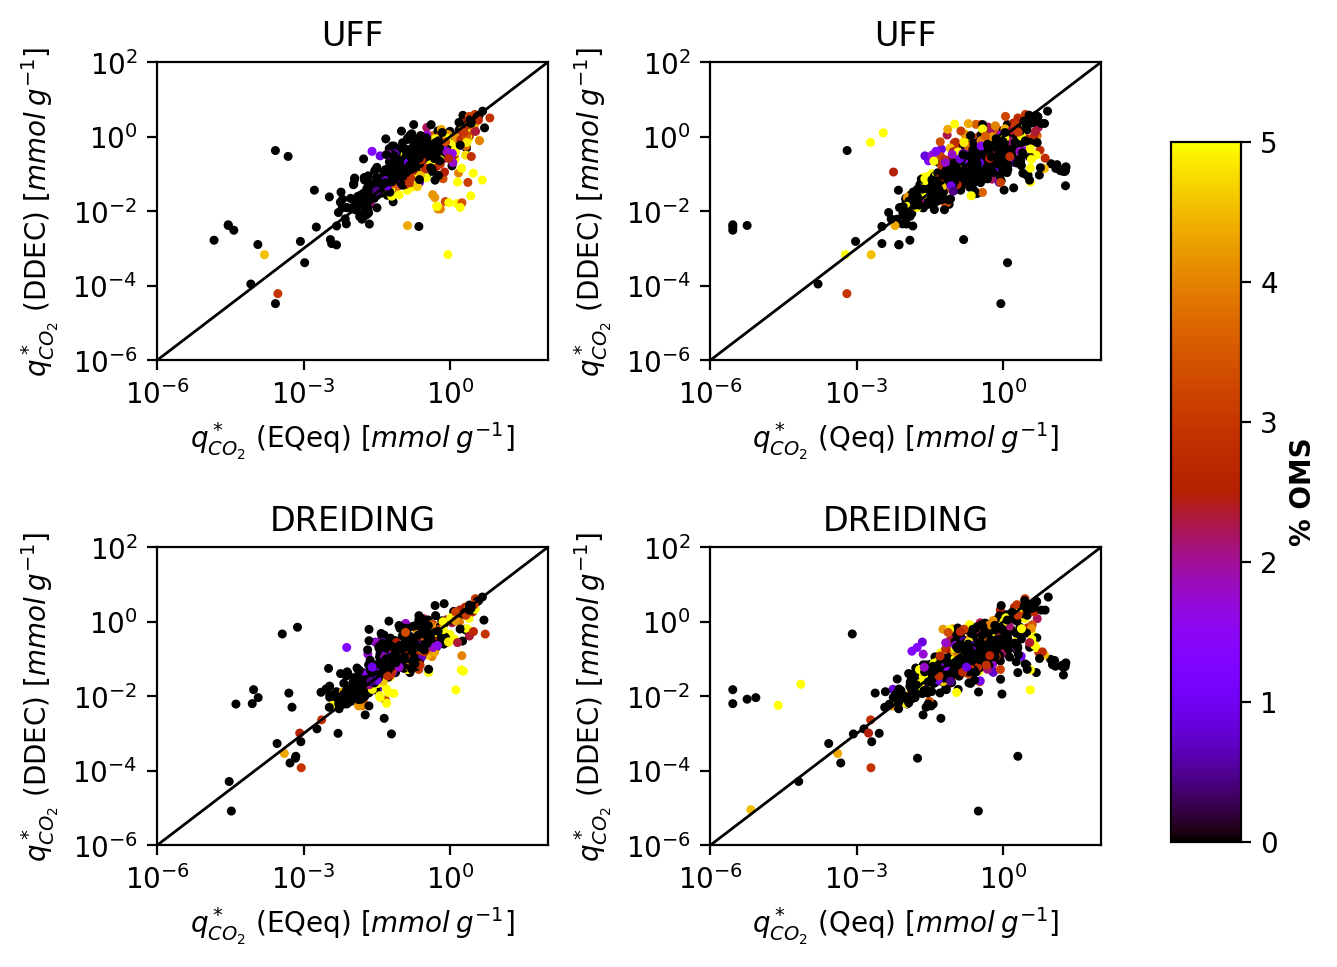

In [17]:
# plot as a function of pressure and charge scheme 
%config InlineBackend.figure_format = 'retina'
cm = plt.cm.get_cmap('gnuplot')

data_lowP_298K = CO2_df[CO2_df['Pressure(Pa)']==1000.0];data_lowP_298K = data_lowP_298K[data_lowP_298K['Temp(K)']==298]
structural_data['oms_percentage'] = structural_data['OMS'] / structural_data['total_atoms'] * 100 

_,ax = plt.subplots(2,2,figsize=(7,5),dpi=100)
ax = ax.flatten()
font = {'size'   : 10}
matplotlib.rc('font', **font)

ID1_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==1],structural_data,on=['Name'])
ID2_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==2],structural_data,on=['Name'])
ID3_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==3],structural_data,on=['Name'])
ID5_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==5],structural_data,on=['Name'])
ID6_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==6],structural_data,on=['Name'])
ID7_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==7],structural_data,on=['Name'])


sc = ax[0].scatter(ID2_data['Loading(mmol/g)'],ID1_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=5,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[0].plot( [0,100],[0,100],'-k',linewidth=1)
ax[0].set(xlabel='$q^*_{CO_2}$ (EQeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='UFF')
ax[0].set_xlim(left=0.000001,right=100)
ax[0].set_ylim(top=100,bottom=0.000001)
ax[0].set_xscale('log')
ax[0].set_yscale('log')


sc = ax[1].scatter(ID3_data['Loading(mmol/g)'],ID1_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=5,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[1].plot( [0,100],[0,100],'-k',linewidth=1)
ax[1].set(xlabel='$q^*_{CO_2}$ (Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='UFF')
ax[1].set_xlim(left=0.000001,right=100)
ax[1].set_ylim(top=100,bottom=0.000001)
ax[1].set_xscale('log')
ax[1].set_yscale('log')



sc = ax[2].scatter(ID6_data['Loading(mmol/g)'],ID5_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=5,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[2].plot( [0,100],[0,100],'-k',linewidth=1)
ax[2].set(xlabel='$q^*_{CO_2}$ (EQeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='DREIDING')
ax[2].set_xlim(left=0.000001,right=100)
ax[2].set_ylim(top=100,bottom=0.000001)
ax[2].set_xscale('log')
ax[2].set_yscale('log')


sc = ax[3].scatter(ID7_data['Loading(mmol/g)'],ID5_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=5,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[3].plot( [0,100],[0,100],'-k',linewidth=1)
ax[3].set(xlabel='$q^*_{CO_2}$ (Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='DREIDING')
ax[3].set_xlim(left=0.000001,right=100)
ax[3].set_ylim(top=100,bottom=0.000001)
ax[3].set_xscale('log')
ax[3].set_yscale('log')


_.tight_layout()
_.subplots_adjust(right=0.8)
cbar_ax = _.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = _.colorbar(sc, cax=cbar_ax)
cbar.set_label(r'% OMS', fontweight='bold')


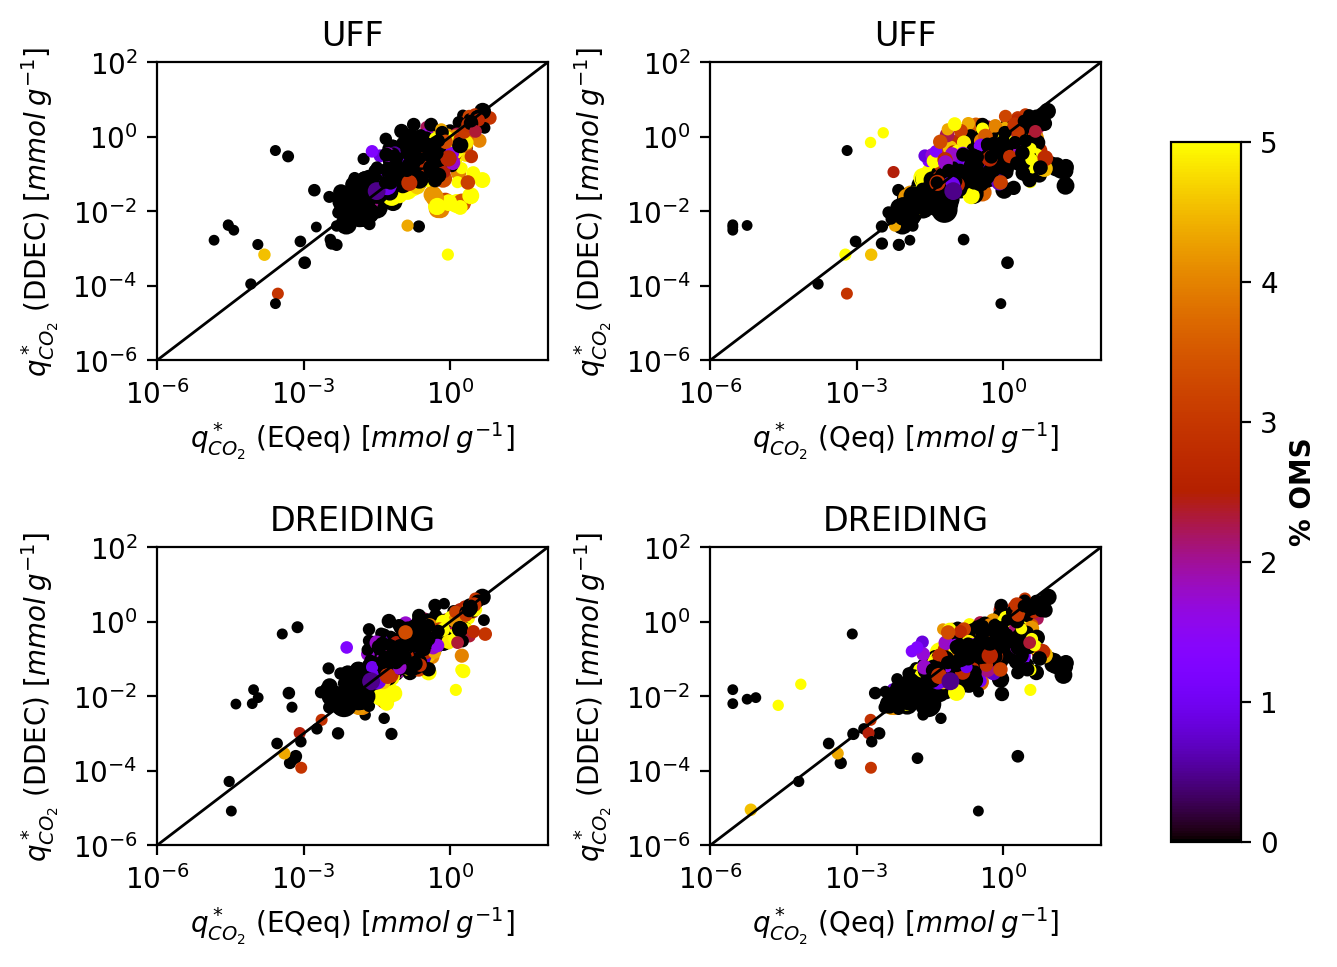

In [18]:
# plot as a function of pressure and charge scheme 
%config InlineBackend.figure_format = 'retina'
cm = plt.cm.get_cmap('gnuplot')

data_lowP_298K = CO2_df[CO2_df['Pressure(Pa)']==1000.0];data_lowP_298K = data_lowP_298K[data_lowP_298K['Temp(K)']==298]
structural_data['oms_percentage'] = structural_data['OMS'] / structural_data['total_atoms'] * 100 

_,ax = plt.subplots(2,2,figsize=(7,5),dpi=100)
ax = ax.flatten()
font = {'size'   : 10}
matplotlib.rc('font', **font)

ID1_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==1],structural_data,on=['Name'])
ID2_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==2],structural_data,on=['Name'])
ID3_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==3],structural_data,on=['Name'])
ID5_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==5],structural_data,on=['Name'])
ID6_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==6],structural_data,on=['Name'])
ID7_data = pd.merge(data_lowP_298K[data_lowP_298K['ID']==7],structural_data,on=['Name'])


sc = ax[0].scatter(ID2_data['Loading(mmol/g)'],ID1_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=ID1_data['LCD']*3,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[0].plot( [0,100],[0,100],'-k',linewidth=1)
ax[0].set(xlabel='$q^*_{CO_2}$ (EQeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='UFF')
ax[0].set_xlim(left=0.000001,right=100)
ax[0].set_ylim(top=100,bottom=0.000001)
ax[0].set_xscale('log')
ax[0].set_yscale('log')


sc = ax[1].scatter(ID3_data['Loading(mmol/g)'],ID1_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=ID1_data['LCD']*3,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[1].plot( [0,100],[0,100],'-k',linewidth=1)
ax[1].set(xlabel='$q^*_{CO_2}$ (Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='UFF')
ax[1].set_xlim(left=0.000001,right=100)
ax[1].set_ylim(top=100,bottom=0.000001)
ax[1].set_xscale('log')
ax[1].set_yscale('log')



sc = ax[2].scatter(ID6_data['Loading(mmol/g)'],ID5_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=ID1_data['LCD']*3,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[2].plot( [0,100],[0,100],'-k',linewidth=1)
ax[2].set(xlabel='$q^*_{CO_2}$ (EQeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='DREIDING')
ax[2].set_xlim(left=0.000001,right=100)
ax[2].set_ylim(top=100,bottom=0.000001)
ax[2].set_xscale('log')
ax[2].set_yscale('log')


sc = ax[3].scatter(ID7_data['Loading(mmol/g)'],ID5_data['Loading(mmol/g)'],c=ID1_data['oms_percentage'],cmap=cm,s=ID1_data['LCD']*3,vmax=5,vmin=0)  # UFF + EQeqCharge 
ax[3].plot( [0,100],[0,100],'-k',linewidth=1)
ax[3].set(xlabel='$q^*_{CO_2}$ (Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]',title='DREIDING')
ax[3].set_xlim(left=0.000001,right=100)
ax[3].set_ylim(top=100,bottom=0.000001)
ax[3].set_xscale('log')
ax[3].set_yscale('log')


_.tight_layout()
_.subplots_adjust(right=0.8)
cbar_ax = _.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = _.colorbar(sc, cax=cbar_ax)
cbar.set_label(r'% OMS', fontweight='bold')


### Get charges

In [10]:
from itertools import chain

def UniqueKeys(arr):
 
    # Stores the list of unique keys
    unique_keys = list(set(chain.from_iterable(sub.keys() for sub in arr)))
 
    return unique_keys

def merge_dictionary_list(dict_list):
    
    return {
    k: list(chain.from_iterable([d.get(k) for d in dict_list if k in d])) #  Go through all elements in dictionary list and get values for current key k if the current dictionary (d) being evaluated actually has that key
    for k in set().union(*dict_list) # gets all keys from list of dictionary and unite them distinctly by using set().union. After all we can only have distinct elements in set data structure.
    }


## path to cif files -- CIF files can be found at https://doi.org/10.5281/zenodo.7106174
ddec_cif_dir = os.path.join(pwd,'CIF_FILES','DDEC')
eqeq_cif_dir = os.path.join(pwd,'CIF_FILES','EQeq')
qeq_cif_dir = os.path.join(pwd,'CIF_FILES','Qeq')

# lists to store information
ddec_charges = []; df_ddec_charges = []
eqeq_charges = []; df_eqeq_charges = []
qeq_charges  = []; df_qeq_charges  = []

for filename in os.listdir(ddec_cif_dir):  
    if filename.split('.')[0] in neverDOE:
        continue
    elif filename.split('.')[0] in badMOFs:
        continue
    else:
        with open(os.path.join(ddec_cif_dir, filename)) as f:  

            content    = f.read()
            cryst_data = content.split('_atom_site_charge',1)[1] 
            split_cryst_data = pd.DataFrame([s.split() for s in cryst_data.splitlines()][1:-2],columns = ['metal','x','y','z','q'])
            metals = split_cryst_data['metal'].unique()
            ddec_atom_charge = {metal: list(split_cryst_data[split_cryst_data['metal']==metal]['q']) for metal in metals}
            ddec_charges.append(ddec_atom_charge)

        with open(os.path.join(eqeq_cif_dir, filename)) as f:                                        
            content    = f.read()
            cryst_data = content.split('_atom_site_charge',1)[1] 
            split_cryst_data = pd.DataFrame([s.split()[1:] for s in cryst_data.splitlines()][1:-2],columns = ['metal','x','y','z','q'])
            eqeq_atom_charge = {metal: list(split_cryst_data[split_cryst_data['metal']==metal]['q']) for metal in metals}
            eqeq_charges.append(eqeq_atom_charge)

        with open(os.path.join(qeq_cif_dir, filename)) as f:                                        
            content    = f.read()
            cryst_data = content.split('_atom_site_charge',1)[1] 
            split_cryst_data = pd.DataFrame([s.split()[1:] for s in cryst_data.splitlines()][1:-2],columns = ['metal','x','y','z','q'])
            qeq_atom_charge = {metal: list(split_cryst_data[split_cryst_data['metal']==metal]['q']) for metal in metals}
            qeq_charges.append(qeq_atom_charge)


merged_ddec_charges = merge_dictionary_list(ddec_charges)
merged_eqeq_charges = merge_dictionary_list(eqeq_charges)
merged_qeq_charges  = merge_dictionary_list(qeq_charges)

## Save dataframes 
# for atom in merged_ddec_charges.keys():
#     atoms_df = pd.DataFrame(list(zip(merged_ddec_charges[atom],merged_eqeq_charges[atom],merged_qeq_charges[atom])),columns=['DDEC','EQeq','Qeq'])
#     atoms_df.to_csv('./atom_charge_csv/{}_charges.csv'.format(atom))
    

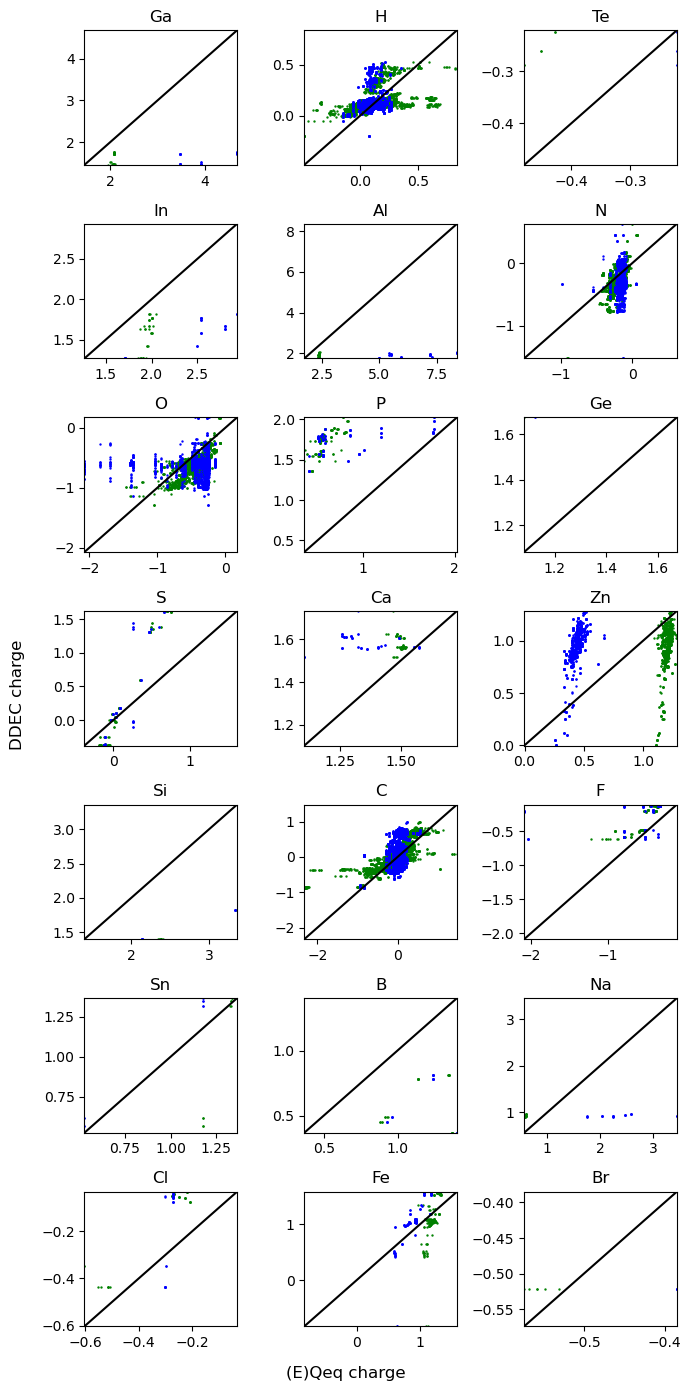

In [11]:
num_atoms = len(merged_ddec_charges)

cols = 3; rows = math.ceil(num_atoms/cols);
fig, ax = plt.subplots(rows,cols,figsize=(7,2*rows),dpi=100)
ax = ax.flatten()
fig.supylabel('DDEC charge')
fig.supxlabel('(E)Qeq charge')

for i,atom in enumerate(merged_ddec_charges.keys()):
    charge_df = pd.read_csv('./atom_charge_csv/{}_charges.csv'.format(atom),index_col=False)
    charge_df.drop(columns=['Unnamed: 0'],inplace=True)
    ax[i].scatter(charge_df['EQeq'],charge_df['DDEC'],color='green',s=.5)
    ax[i].scatter(charge_df['Qeq'],charge_df['DDEC'],color='blue',s=.5)
    ax[i].set(title='{}'.format(atom))
    ax[i].plot([min([min(charge_df['DDEC']),min(charge_df['EQeq']),min(charge_df['Qeq'])]),max([max(charge_df['DDEC']),max(charge_df['EQeq']),max(charge_df['Qeq'])])],
               [min([min(charge_df['DDEC']),min(charge_df['EQeq']),min(charge_df['Qeq'])]),max([max(charge_df['DDEC']),max(charge_df['EQeq']),max(charge_df['Qeq'])])],'-k')
    ax[i].set_xlim([min([min(charge_df['DDEC']),min(charge_df['EQeq']),min(charge_df['Qeq'])]),max([max(charge_df['DDEC']),max(charge_df['EQeq']),max(charge_df['Qeq'])])])
    ax[i].set_ylim([min([min(charge_df['DDEC']),min(charge_df['EQeq']),min(charge_df['Qeq'])]),max([max(charge_df['DDEC']),max(charge_df['EQeq']),max(charge_df['Qeq'])])])
fig.tight_layout()


## Plot correaltion across all pressures

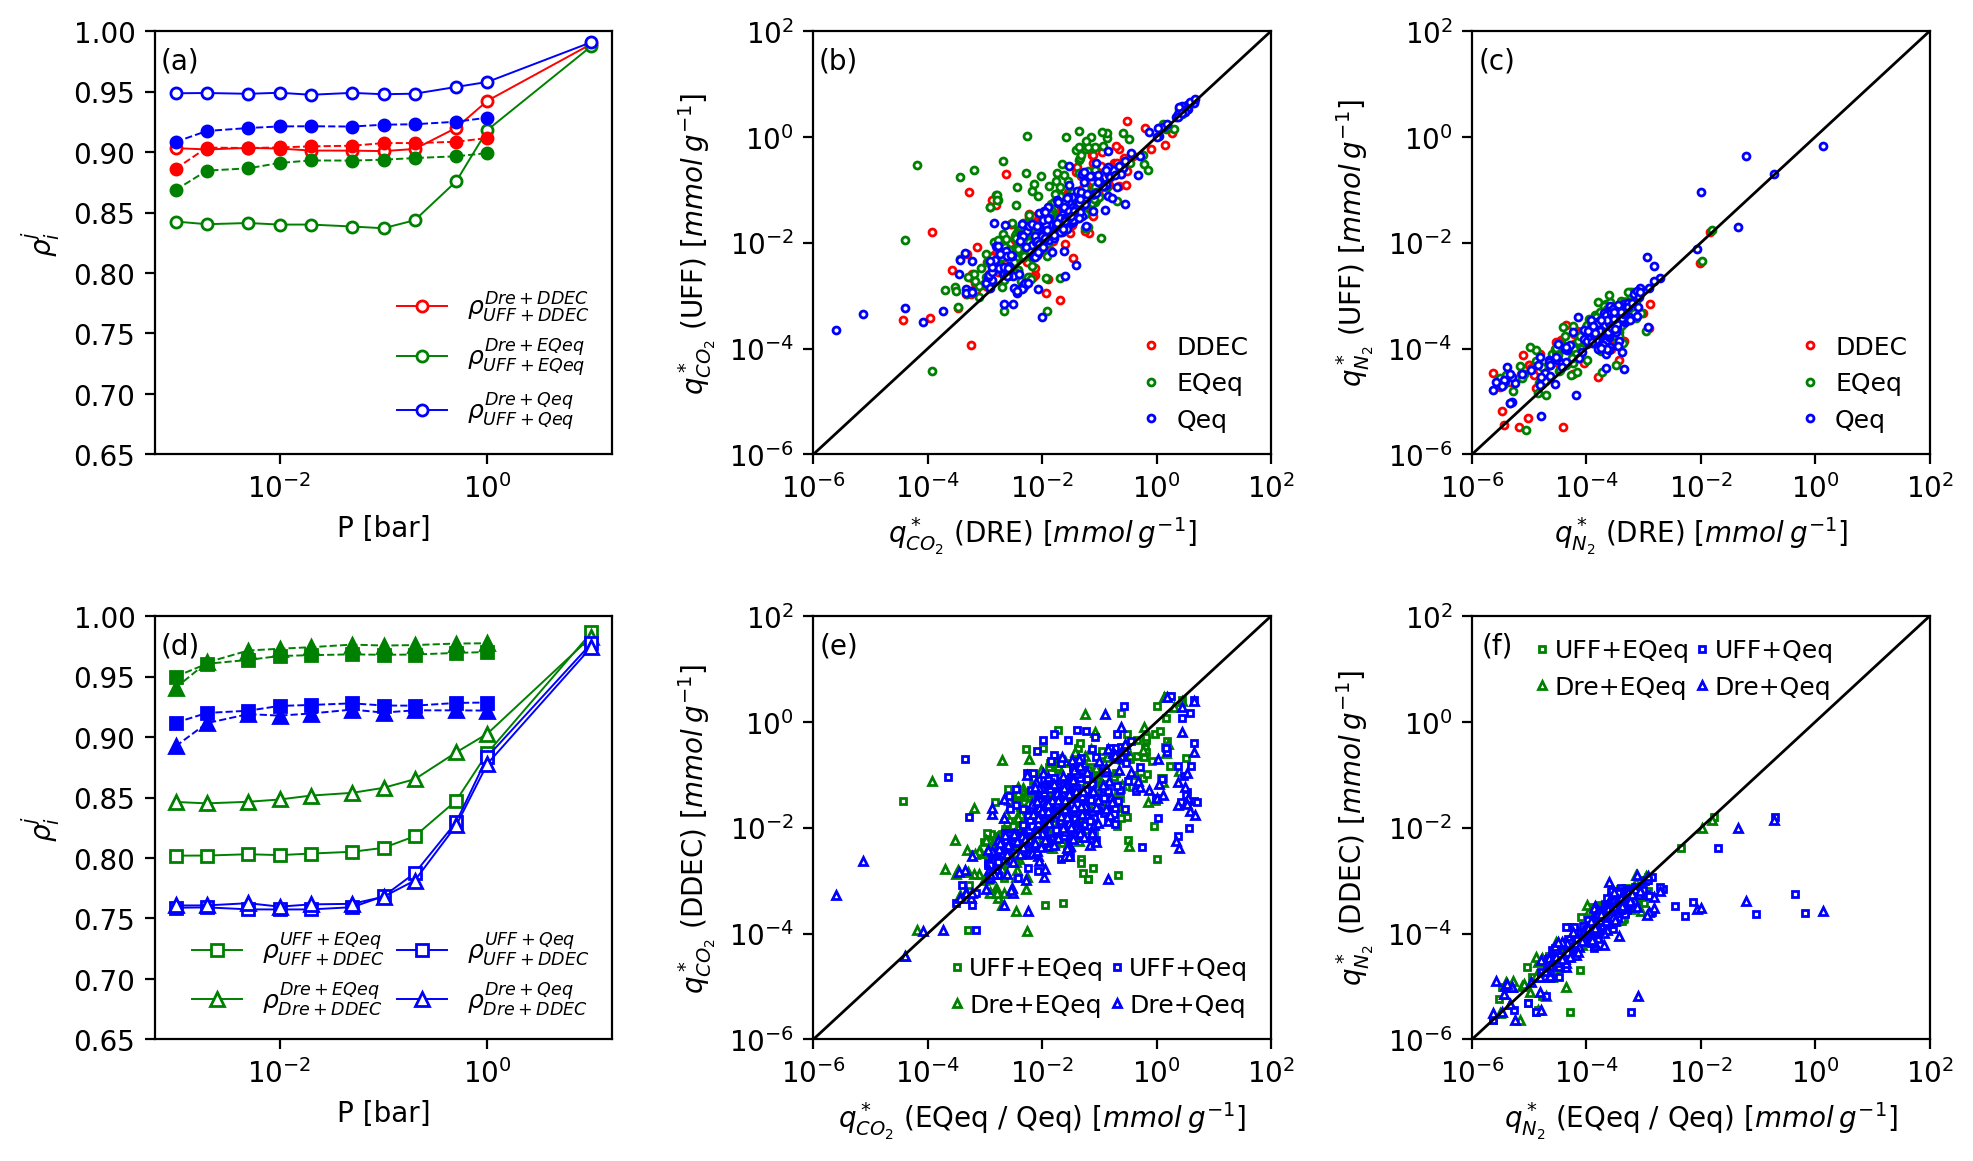

In [28]:
# plot as a function of pressure and charge scheme 
%config InlineBackend.figure_format = 'retina'

N2_data = N2_df[~N2_df['Name'].isin(neverDOE)]; N2_data = N2_data[~N2_data['Name'].isin(badMOFs)]
CO2_data = CO2_df[~CO2_df['Name'].isin(neverDOE)]; CO2_data = CO2_data[~CO2_data['Name'].isin(badMOFs)];

P = CO2_df['Pressure(Pa)'].unique()
lowP = 100.0
_,ax = plt.subplots(2,3,figsize=(10,6),dpi=100)
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = ax.flatten()

# ************************************** CORRELATIONS ******************************************************
ddec, eqeq, qeq = [], [], [] # consistent charges, different LJ FFs
uff_eqeq, uff_qeq, dre_eqeq, dre_qeq = [], [], [], [] # different charges, consistent LJ FFs

for p in P:
    ddec.append(get_spearmanr(CO2_df,298,p,[[1,5]]))
    eqeq.append(get_spearmanr(CO2_df,298,p,[[2,6]]))
    qeq.append(get_spearmanr(CO2_df,298,p,[[3,7]]))
    uff_eqeq.append(get_spearmanr(CO2_df,298,p,[[1,2]]))
    uff_qeq.append(get_spearmanr(CO2_df,298,p,[[1,3]]))
    dre_eqeq.append(get_spearmanr(CO2_df,298,p,[[5,6]]))
    dre_qeq.append(get_spearmanr(CO2_df,298,p,[[5,7]]))
    
ax[0].plot(P/1e5,ddec,lw=0.7,marker='o',mec='r',ms=4,mfc='w',c='r',label=r'$\rho_{UFF+DDEC}^{Dre+DDEC}$')
ax[0].plot(P/1e5,eqeq,lw=0.7,marker='o',mec='g',ms=4,mfc='w',c='g',label=r'$\rho_{UFF+EQeq}^{Dre+EQeq}$')
ax[0].plot(P/1e5,qeq,lw=0.7,marker='o',mec='b',ms=4,mfc='w',c='b',label=r'$\rho_{UFF+Qeq}^{Dre+Qeq}$')
ax[0].set_xscale('log')
ax[0].set(ylabel=r'$\rho_i^j$',xlabel='P [bar]')
ax[0].set_ylim([0.65, 1])
ax[0].minorticks_off()
ax[0].text(0.055, 0.93,'(a)', ha='center', va='center', transform=ax[0].transAxes)
ax[0].legend(loc='lower right',fontsize=9,frameon=False)

ax[3].plot(P/1e5,uff_eqeq,lw=0.7,marker='s',mec='g',ms=4,mfc='w',c='g',label=r'$\rho_{UFF+DDEC}^{UFF+EQeq}$')
ax[3].plot(P/1e5,dre_eqeq,lw=0.7,marker='^',mec='g',ms=5,mfc='w',c='g',label=r'$\rho_{Dre+DDEC}^{Dre+EQeq}$')
ax[3].plot(P/1e5,uff_qeq,lw=0.7,marker='s',mec='b',ms=4,mfc='w',c='b',label=r'$\rho_{UFF+DDEC}^{UFF+Qeq}$')
ax[3].plot(P/1e5,dre_qeq,lw=0.7,marker='^',mec='b',ms=5,mfc='w',c='b',label=r'$\rho_{Dre+DDEC}^{Dre+Qeq}$')
ax[3].set_xscale('log')
ax[3].set(ylabel=r'$\rho_i^j$',xlabel='P [bar]')
ax[3].set_ylim([0.65, 1])
ax[3].minorticks_off()
ax[3].text(0.055, 0.93,'(d)', ha='center', va='center', transform=ax[3].transAxes)
ax[3].legend(loc='lower right',fontsize=9,frameon=False,ncol=2,columnspacing=.5)

# ****************************************************** N2 ********************************************************
ddec, eqeq, qeq = [], [], [] # consistent charges, different LJ FFs
uff_eqeq, uff_qeq, dre_eqeq, dre_qeq = [], [], [], [] # different charges, consistent LJ FFs

for p in P:
    ddec.append(get_spearmanr(N2_df,298,p,[[1,5]]))
    eqeq.append(get_spearmanr(N2_df,298,p,[[2,6]]))
    qeq.append(get_spearmanr(N2_df,298,p,[[3,7]]))
    uff_eqeq.append(get_spearmanr(N2_df,298,p,[[1,2]]))
    uff_qeq.append(get_spearmanr(N2_df,298,p,[[1,3]]))
    dre_eqeq.append(get_spearmanr(N2_df,298,p,[[5,6]]))
    dre_qeq.append(get_spearmanr(N2_df,298,p,[[5,7]]))
    
ax[0].plot(P/1e5,ddec,lw=0.7,ls='--',marker='o',mec='r',ms=4,mfc='r',c='r')
ax[0].plot(P/1e5,eqeq,lw=0.7,ls='--',marker='o',mec='g',ms=4,mfc='g',c='g')
ax[0].plot(P/1e5,qeq,lw=0.7,ls='--',marker='o',mec='b',ms=4,mfc='b',c='b')

ax[3].plot(P/1e5,uff_eqeq,lw=0.7,ls='--',marker='s',mec='g',ms=4,mfc='g',c='g')
ax[3].plot(P/1e5,dre_eqeq,lw=0.7,ls='--',marker='^',mec='g',ms=5,mfc='g',c='g')
ax[3].plot(P/1e5,uff_qeq,lw=0.7,ls='--',marker='s',mec='b',ms=4,mfc='b',c='b')
ax[3].plot(P/1e5,dre_qeq,lw=0.7,ls='--',marker='^',mec='b',ms=5,mfc='b',c='b')

# *************************************** PARITY PLOTS *********************************************************
P_low = CO2_data[CO2_data['Pressure(Pa)']==lowP]; P_low = P_low[P_low['Temp(K)']==298]
ax[1].plot(P_low[P_low['ID']==5]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'o',mec='r',ms=2.5,mfc='w',label='DDEC')  # DDEC Charge 
ax[1].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==2]['Loading(mmol/g)'],'o',mec='g',ms=2.5,mfc='w',label='EQeq')  # EQeq Charge 
ax[1].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==3]['Loading(mmol/g)'],'o',mec='b',ms=2.5,mfc='w',label='Qeq')  # Qeq Charge 
ax[1].plot( [0,100],[0,100],'-k',linewidth=1)
ax[1].set(xlabel='$q^*_{CO_2}$ (DRE) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (UFF) [$mmol \: g^{-1}$]')
ax[1].set_xlim(left=0.000001,right=100)
ax[1].set_ylim(top=100,bottom=0.000001)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(frameon=False,loc='lower right',handletextpad=0.01,fontsize=9)
# ax[1].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[1].transAxes)
ax[1].text(0.055, 0.93,'(b)', ha='center', va='center', transform=ax[1].transAxes)

ax[4].plot(P_low[P_low['ID']==2]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='g',ms=2.5,mfc='w',c='g',label='UFF+EQeq')  # UFF + EQeqCharge 
ax[4].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='g',ms=3,mfc='w',c='g',label='Dre+EQeq')  # DRE + EQeq Charge 
ax[4].plot(P_low[P_low['ID']==3]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='b',ms=2.5,mfc='w',c='b',label='UFF+Qeq')  # UFF + Qeq Charge 
ax[4].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='b',ms=3,mfc='w',c='b',label='Dre+Qeq')  # DRE + Qeq Charge 
ax[4].plot( [0,100],[0,100],'-k',linewidth=1)
ax[4].set(xlabel='$q^*_{CO_2}$ (EQeq / Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]')
ax[4].set_xlim(left=0.000001,right=100)
ax[4].set_ylim(top=100,bottom=0.000001)
ax[4].set_xscale('log')
ax[4].set_yscale('log')
ax[4].legend(frameon=False,loc='lower right',handletextpad=-.5,ncol=2,columnspacing=-.5,fontsize=9)
# ax[4].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[4].transAxes)
ax[4].text(0.055, 0.93,'(e)', ha='center', va='center', transform=ax[4].transAxes)

P_low = N2_data[N2_data['Pressure(Pa)']==lowP]; P_low = P_low[P_low['Temp(K)']==298]
ax[2].plot(P_low[P_low['ID']==5]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'o',mec='r',ms=2.5,mfc='w',label='DDEC')  # DDEC Charge 
ax[2].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==2]['Loading(mmol/g)'],'o',mec='g',ms=2.5,mfc='w',label='EQeq')  # EQeq Charge 
ax[2].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==3]['Loading(mmol/g)'],'o',mec='b',ms=2.5,mfc='w',label='Qeq')  # Qeq Charge 
ax[2].plot( [0,100],[0,100],'-k',linewidth=1)
ax[2].set(xlabel='$q^*_{N_2}$ (DRE) [$mmol \: g^{-1}$]',ylabel='$q^*_{N_2}$ (UFF) [$mmol \: g^{-1}$]')
ax[2].set_xlim(left=0.000001,right=100)
ax[2].set_ylim(top=100,bottom=0.000001)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend(frameon=False,loc='lower right',handletextpad=0.01,fontsize=9)
# ax[2].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[2].transAxes)
ax[2].text(0.055, 0.93,'(c)', ha='center', va='center', transform=ax[2].transAxes)

ax[5].plot(P_low[P_low['ID']==2]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='g',ms=2.5,mfc='w',c='g',label='UFF+EQeq')  # UFF + EQeqCharge 
ax[5].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='g',ms=3,mfc='w',c='g',label='Dre+EQeq')  # DRE + EQeq Charge 
ax[5].plot(P_low[P_low['ID']==3]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='b',ms=2.5,mfc='w',c='b',label='UFF+Qeq')  # UFF + Qeq Charge 
ax[5].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='b',ms=3,mfc='w',c='b',label='Dre+Qeq')  # DRE + Qeq Charge 
ax[5].plot( [0,100],[0,100],'-k',linewidth=1)
ax[5].set(xlabel='$q^*_{N_2}$ (EQeq / Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{N_2}$ (DDEC) [$mmol \: g^{-1}$]')
ax[5].set_xlim(left=0.000001,right=100)
ax[5].set_ylim(top=100,bottom=0.000001)
ax[5].set_xscale('log')
ax[5].set_yscale('log')
ax[5].legend(frameon=False,loc='upper left',bbox_to_anchor=(0.05, 1.0),handletextpad=-0.5,ncol=2,columnspacing=-.5,fontsize=9)
# ax[5].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[5].transAxes)
ax[5].text(0.055, 0.93,'(f)', ha='center', va='center', transform=ax[5].transAxes)

_.tight_layout()
plt.savefig('Figure.png', dpi=500)


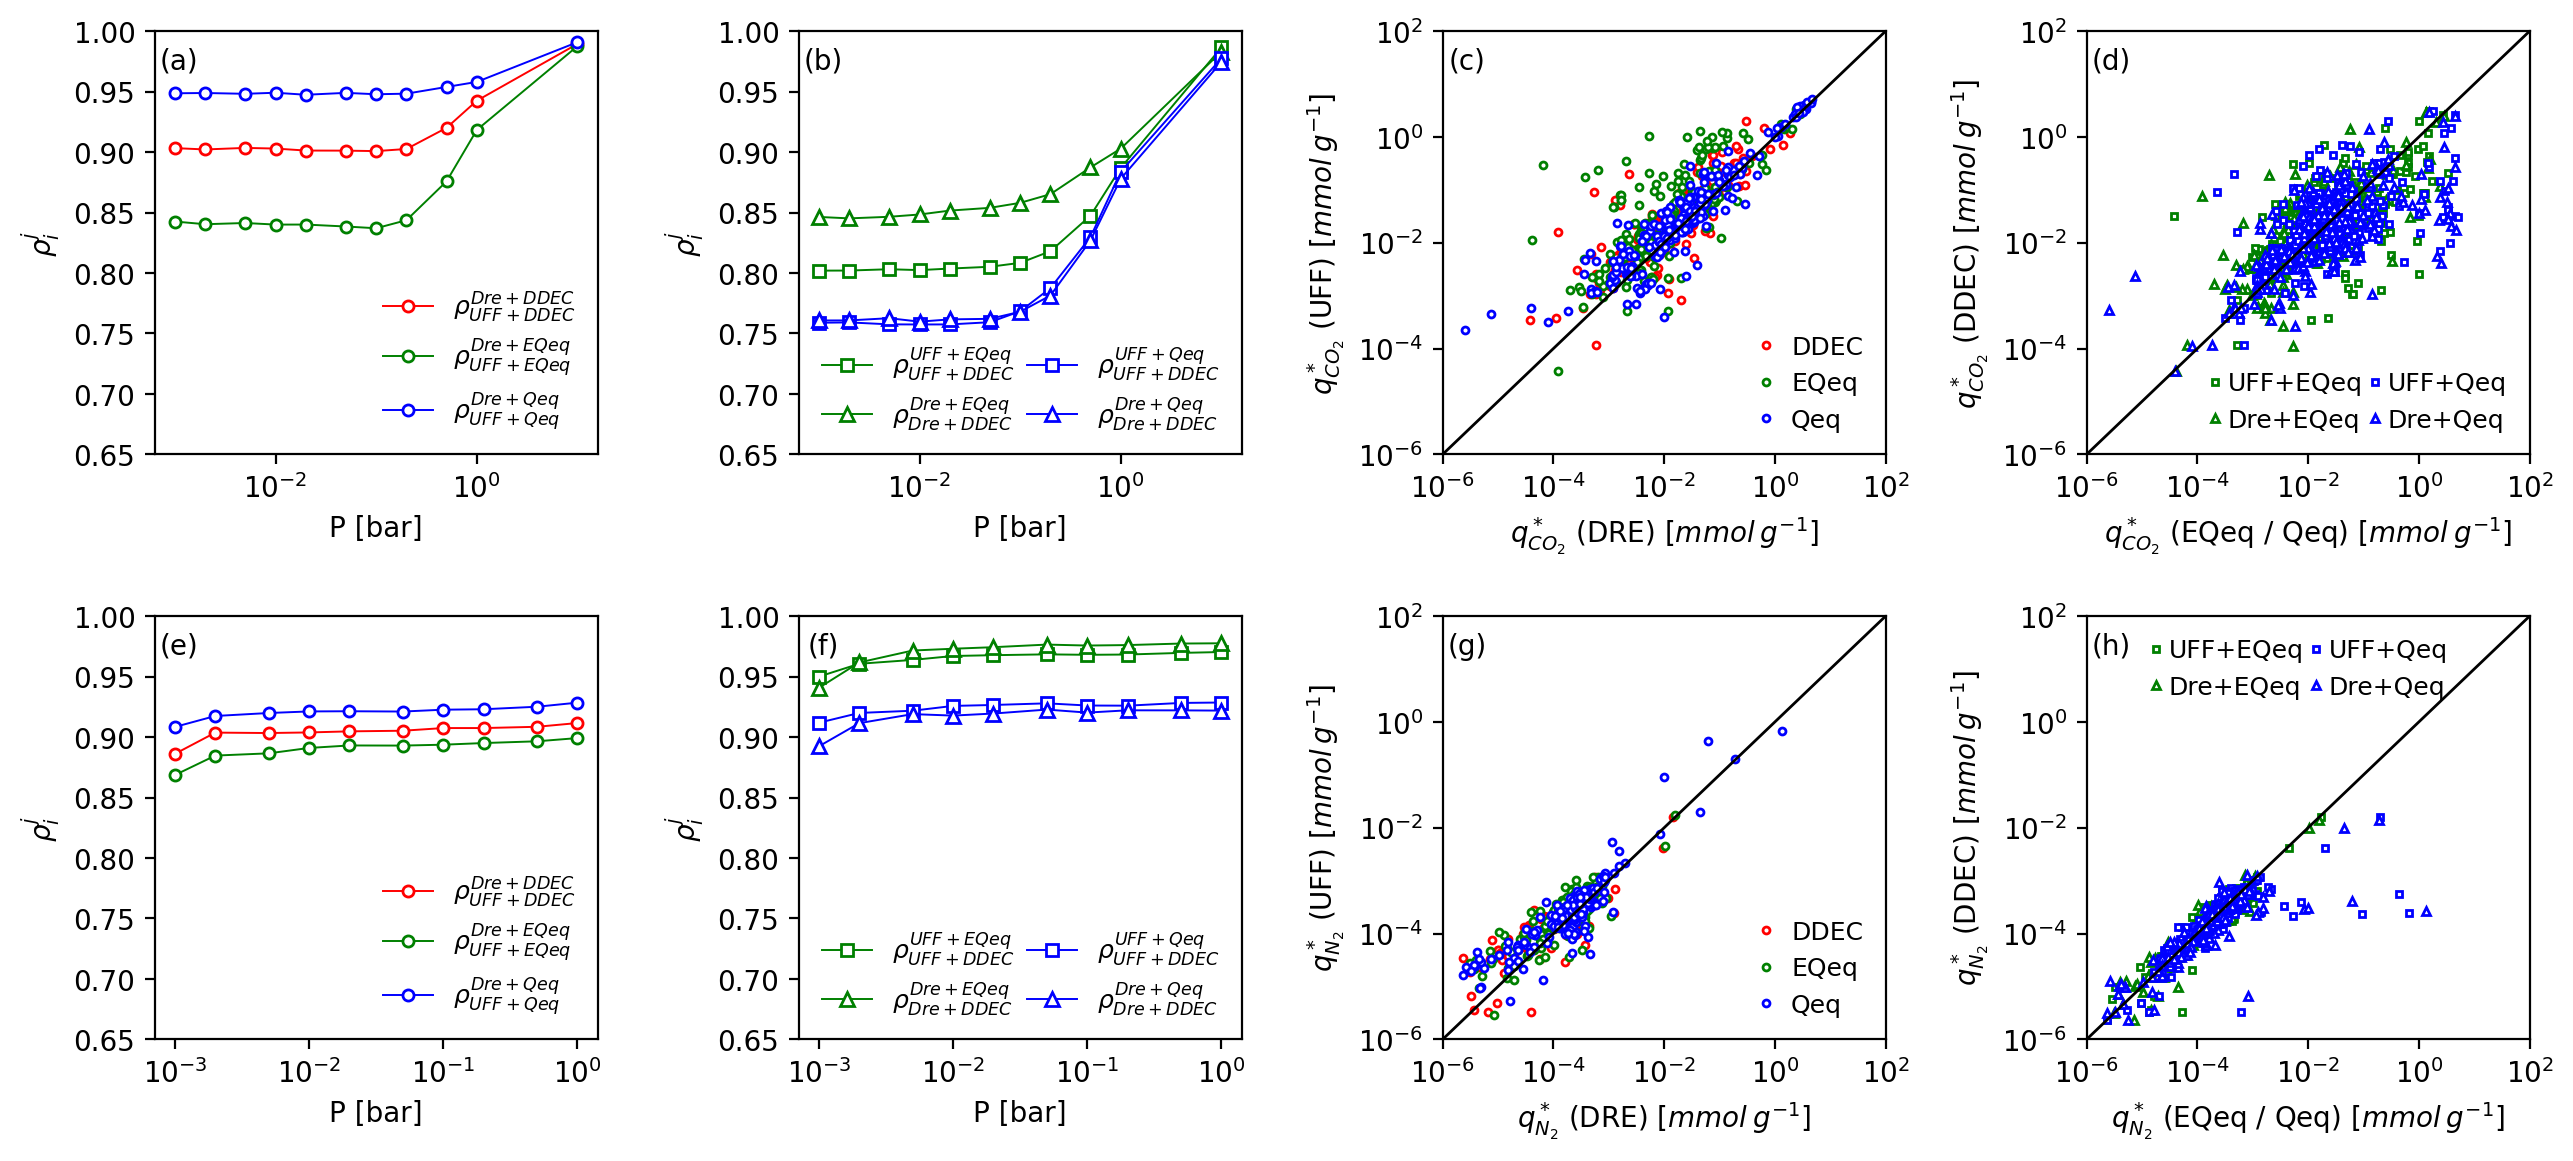

In [43]:
# plot as a function of pressure and charge scheme 
%config InlineBackend.figure_format = 'retina'

N2_data = N2_df[~N2_df['Name'].isin(neverDOE)]; N2_data = N2_data[~N2_data['Name'].isin(badMOFs)]
CO2_data = CO2_df[~CO2_df['Name'].isin(neverDOE)]; CO2_data = CO2_data[~CO2_data['Name'].isin(badMOFs)];

P = CO2_df['Pressure(Pa)'].unique()
lowP = 100.0
_,ax = plt.subplots(2,4,figsize=(13,6),dpi=100)
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = ax.flatten()
label = {0: '(a)',
         1: '(b)',
         2: '(c)',
         3: '(d)',
         4: '(e)',
         5: '(f)',
         6: '(g)',
         7: '(h)'}

# ************************************** CORRELATIONS ******************************************************
ddec, eqeq, qeq = [], [], [] # consistent charges, different LJ FFs
uff_eqeq, uff_qeq, dre_eqeq, dre_qeq = [], [], [], [] # different charges, consistent LJ FFs

for p in P:
    ddec.append(get_spearmanr(CO2_df,298,p,[[1,5]]))
    eqeq.append(get_spearmanr(CO2_df,298,p,[[2,6]]))
    qeq.append(get_spearmanr(CO2_df,298,p,[[3,7]]))
    uff_eqeq.append(get_spearmanr(CO2_df,298,p,[[1,2]]))
    uff_qeq.append(get_spearmanr(CO2_df,298,p,[[1,3]]))
    dre_eqeq.append(get_spearmanr(CO2_df,298,p,[[5,6]]))
    dre_qeq.append(get_spearmanr(CO2_df,298,p,[[5,7]]))

idx = 0   
ax[idx].plot(P/1e5,ddec,lw=0.7,marker='o',mec='r',ms=4,mfc='w',c='r',label=r'$\rho_{UFF+DDEC}^{Dre+DDEC}$')
ax[idx].plot(P/1e5,eqeq,lw=0.7,marker='o',mec='g',ms=4,mfc='w',c='g',label=r'$\rho_{UFF+EQeq}^{Dre+EQeq}$')
ax[idx].plot(P/1e5,qeq,lw=0.7,marker='o',mec='b',ms=4,mfc='w',c='b',label=r'$\rho_{UFF+Qeq}^{Dre+Qeq}$')
ax[idx].set_xscale('log')
ax[idx].set(ylabel=r'$\rho_i^j$',xlabel='P [bar]')
ax[idx].set_ylim([0.65, 1])
ax[idx].minorticks_off()
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)
ax[idx].legend(loc='lower right',fontsize=9,frameon=False)

idx = 1
ax[idx].plot(P/1e5,uff_eqeq,lw=0.7,marker='s',mec='g',ms=4,mfc='w',c='g',label=r'$\rho_{UFF+DDEC}^{UFF+EQeq}$')
ax[idx].plot(P/1e5,dre_eqeq,lw=0.7,marker='^',mec='g',ms=5,mfc='w',c='g',label=r'$\rho_{Dre+DDEC}^{Dre+EQeq}$')
ax[idx].plot(P/1e5,uff_qeq,lw=0.7,marker='s',mec='b',ms=4,mfc='w',c='b',label=r'$\rho_{UFF+DDEC}^{UFF+Qeq}$')
ax[idx].plot(P/1e5,dre_qeq,lw=0.7,marker='^',mec='b',ms=5,mfc='w',c='b',label=r'$\rho_{Dre+DDEC}^{Dre+Qeq}$')
ax[idx].set_xscale('log')
ax[idx].set(ylabel=r'$\rho_i^j$',xlabel='P [bar]')
ax[idx].set_ylim([0.65, 1])
ax[idx].minorticks_off()
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)
ax[idx].legend(loc='lower right',fontsize=9,frameon=False,ncol=2,columnspacing=.5)

# ****************************************************** N2 ********************************************************
ddec, eqeq, qeq = [], [], [] # consistent charges, different LJ FFs
uff_eqeq, uff_qeq, dre_eqeq, dre_qeq = [], [], [], [] # different charges, consistent LJ FFs

for p in P:
    ddec.append(get_spearmanr(N2_df,298,p,[[1,5]]))
    eqeq.append(get_spearmanr(N2_df,298,p,[[2,6]]))
    qeq.append(get_spearmanr(N2_df,298,p,[[3,7]]))
    uff_eqeq.append(get_spearmanr(N2_df,298,p,[[1,2]]))
    uff_qeq.append(get_spearmanr(N2_df,298,p,[[1,3]]))
    dre_eqeq.append(get_spearmanr(N2_df,298,p,[[5,6]]))
    dre_qeq.append(get_spearmanr(N2_df,298,p,[[5,7]]))

idx = 4    
ax[idx].plot(P/1e5,ddec,lw=0.7,ls='-',marker='o',mec='r',ms=4,mfc='w',c='r',label=r'$\rho_{UFF+DDEC}^{Dre+DDEC}$')
ax[idx].plot(P/1e5,eqeq,lw=0.7,ls='-',marker='o',mec='g',ms=4,mfc='w',c='g',label=r'$\rho_{UFF+EQeq}^{Dre+EQeq}$')
ax[idx].plot(P/1e5,qeq,lw=0.7,ls='-',marker='o',mec='b',ms=4,mfc='w',c='b',label=r'$\rho_{UFF+Qeq}^{Dre+Qeq}$')
ax[idx].set_xscale('log')
ax[idx].set(ylabel=r'$\rho_i^j$',xlabel='P [bar]')
ax[idx].set_ylim([0.65, 1])
ax[idx].minorticks_off()
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)
ax[idx].legend(loc='lower right',fontsize=9,frameon=False)

idx = 5
ax[idx].plot(P/1e5,uff_eqeq,lw=0.7,ls='-',marker='s',mec='g',ms=4,mfc='w',c='g',label=r'$\rho_{UFF+DDEC}^{UFF+EQeq}$')
ax[idx].plot(P/1e5,dre_eqeq,lw=0.7,ls='-',marker='^',mec='g',ms=5,mfc='w',c='g',label=r'$\rho_{Dre+DDEC}^{Dre+EQeq}$')
ax[idx].plot(P/1e5,uff_qeq,lw=0.7,ls='-',marker='s',mec='b',ms=4,mfc='w',c='b',label=r'$\rho_{UFF+DDEC}^{UFF+Qeq}$')
ax[idx].plot(P/1e5,dre_qeq,lw=0.7,ls='-',marker='^',mec='b',ms=5,mfc='w',c='b',label=r'$\rho_{Dre+DDEC}^{Dre+Qeq}$')
ax[idx].set_xscale('log')
ax[idx].set(ylabel=r'$\rho_i^j$',xlabel='P [bar]')
ax[idx].set_ylim([0.65, 1])
ax[idx].minorticks_off()
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)
ax[idx].legend(loc='lower right',fontsize=9,frameon=False,ncol=2,columnspacing=.5)

# *************************************** PARITY PLOTS *********************************************************
P_low = CO2_data[CO2_data['Pressure(Pa)']==lowP]; P_low = P_low[P_low['Temp(K)']==298]
idx = 2
ax[idx].plot(P_low[P_low['ID']==5]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'o',mec='r',ms=2.5,mfc='w',label='DDEC')  # DDEC Charge 
ax[idx].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==2]['Loading(mmol/g)'],'o',mec='g',ms=2.5,mfc='w',label='EQeq')  # EQeq Charge 
ax[idx].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==3]['Loading(mmol/g)'],'o',mec='b',ms=2.5,mfc='w',label='Qeq')  # Qeq Charge 
ax[idx].plot( [0,100],[0,100],'-k',linewidth=1)
ax[idx].set(xlabel='$q^*_{CO_2}$ (DRE) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (UFF) [$mmol \: g^{-1}$]')
ax[idx].set_xlim(left=0.000001,right=100)
ax[idx].set_ylim(top=100,bottom=0.000001)
ax[idx].set_xscale('log')
ax[idx].set_yscale('log')
ax[idx].legend(frameon=False,loc='lower right',handletextpad=0.01,fontsize=9)
# ax[1].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[1].transAxes)
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)

idx = 3
ax[idx].plot(P_low[P_low['ID']==2]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='g',ms=2.5,mfc='w',c='g',label='UFF+EQeq')  # UFF + EQeqCharge 
ax[idx].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='g',ms=3,mfc='w',c='g',label='Dre+EQeq')  # DRE + EQeq Charge 
ax[idx].plot(P_low[P_low['ID']==3]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='b',ms=2.5,mfc='w',c='b',label='UFF+Qeq')  # UFF + Qeq Charge 
ax[idx].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='b',ms=3,mfc='w',c='b',label='Dre+Qeq')  # DRE + Qeq Charge 
ax[idx].plot( [0,100],[0,100],'-k',linewidth=1)
ax[idx].set(xlabel='$q^*_{CO_2}$ (EQeq / Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{CO_2}$ (DDEC) [$mmol \: g^{-1}$]')
ax[idx].set_xlim(left=0.000001,right=100)
ax[idx].set_ylim(top=100,bottom=0.000001)
ax[idx].set_xscale('log')
ax[idx].set_yscale('log')
ax[idx].legend(frameon=False,loc='lower right',handletextpad=-.5,ncol=2,columnspacing=-.5,fontsize=9)
# ax[4].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[4].transAxes)
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)


P_low = N2_data[N2_data['Pressure(Pa)']==lowP]; P_low = P_low[P_low['Temp(K)']==298]
idx = 6
ax[idx].plot(P_low[P_low['ID']==5]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'o',mec='r',ms=2.5,mfc='w',label='DDEC')  # DDEC Charge 
ax[idx].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==2]['Loading(mmol/g)'],'o',mec='g',ms=2.5,mfc='w',label='EQeq')  # EQeq Charge 
ax[idx].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==3]['Loading(mmol/g)'],'o',mec='b',ms=2.5,mfc='w',label='Qeq')  # Qeq Charge 
ax[idx].plot( [0,100],[0,100],'-k',linewidth=1)
ax[idx].set(xlabel='$q^*_{N_2}$ (DRE) [$mmol \: g^{-1}$]',ylabel='$q^*_{N_2}$ (UFF) [$mmol \: g^{-1}$]')
ax[idx].set_xlim(left=0.000001,right=100)
ax[idx].set_ylim(top=100,bottom=0.000001)
ax[idx].set_xscale('log')
ax[idx].set_yscale('log')
ax[idx].legend(frameon=False,loc='lower right',handletextpad=0.01,fontsize=9)
# ax[2].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[2].transAxes)
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)

idx = 7
ax[idx].plot(P_low[P_low['ID']==2]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='g',ms=2.5,mfc='w',c='g',label='UFF+EQeq')  # UFF + EQeqCharge 
ax[idx].plot(P_low[P_low['ID']==6]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='g',ms=3,mfc='w',c='g',label='Dre+EQeq')  # DRE + EQeq Charge 
ax[idx].plot(P_low[P_low['ID']==3]['Loading(mmol/g)'],P_low[P_low['ID']==1]['Loading(mmol/g)'],'s',mec='b',ms=2.5,mfc='w',c='b',label='UFF+Qeq')  # UFF + Qeq Charge 
ax[idx].plot(P_low[P_low['ID']==7]['Loading(mmol/g)'],P_low[P_low['ID']==5]['Loading(mmol/g)'],'^',mec='b',ms=3,mfc='w',c='b',label='Dre+Qeq')  # DRE + Qeq Charge 
ax[idx].plot( [0,100],[0,100],'-k',linewidth=1)
ax[idx].set(xlabel='$q^*_{N_2}$ (EQeq / Qeq) [$mmol \: g^{-1}$]',ylabel='$q^*_{N_2}$ (DDEC) [$mmol \: g^{-1}$]')
ax[idx].set_xlim(left=0.000001,right=100)
ax[idx].set_ylim(top=100,bottom=0.000001)
ax[idx].set_xscale('log')
ax[idx].set_yscale('log')
ax[idx].legend(frameon=False,loc='upper left',bbox_to_anchor=(0.05, 1.0),handletextpad=-0.5,ncol=2,columnspacing=-.5,fontsize=9)
# ax[5].text(0.125,0.91,'P = {} bar'.format(lowP/1e5),transform=ax[5].transAxes)
ax[idx].text(0.055, 0.93,label[idx], ha='center', va='center', transform=ax[idx].transAxes)

_.tight_layout()
plt.savefig('Figure2.png', dpi=500)

## Visualise individual isotherms

In [46]:
mofs_demonstrating_diff_between_FFs = ['GIMVAA','BEPNIV','BOMCUB','EBOTOF']


In [49]:
num_materials = len(mofs_demonstrating_diff_between_FFs)

cols = 2; rows = math.ceil(num_materials/cols);
ff_dict = {'UFF+DDEC':1,
          'UFF+EQeq':2,
          'UFF+Qeq': 3,
          'UFF+NEUTRAL': 4,
          'DREIDING+DDEC':5, 
          'DREIDING+EQeq':6,
          'DREIDING+Qeq':7,
          'DREIDING+NEUTRAL':8}

fig,ax = plt.subplots(rows,cols,figsize=(11,3.25*rows),dpi=500)
l = 0
next_researcher = 0

# *********************************************************** CHOOSE TEMPERATURE ****************************************
Temp = 298
# ***********************************************************************************************************************
for i in range(rows):
    for j in range(cols):
        if num_materials == l:
            break
        else:
            material = mofs_demonstrating_diff_between_FFs[next_researcher] # get dataframe for an individual ID (forcefield combination)
            
            # partition data by temperature
            CO2_data = CO2_df[CO2_df['Name']==material]; CO2_data = CO2_data[CO2_data['Temp(K)']==Temp];
                        
            # errorbar the data by temperature
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==1]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==1]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==1]['Mean_Error(mmol/g)'],fmt='-r',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==2]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==2]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==2]['Mean_Error(mmol/g)'],fmt='-g',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==3]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==3]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==3]['Mean_Error(mmol/g)'],fmt='-b',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==4]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==4]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==4]['Mean_Error(mmol/g)'],fmt='-k',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==5]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==5]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==5]['Mean_Error(mmol/g)'],fmt='--r',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==6]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==6]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==6]['Mean_Error(mmol/g)'],fmt='--g',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==7]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==7]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==7]['Mean_Error(mmol/g)'],fmt='--b',capsize=3)
            ax[i][j].errorbar(CO2_data[CO2_data['ID']==8]['Pressure(Pa)']/1e5,CO2_data[CO2_data['ID']==8]['Loading(mmol/g)'],yerr=CO2_data[CO2_data['ID']==8]['Mean_Error(mmol/g)'],fmt='--k',capsize=3)
            ax[i][j].grid(b='none')
            ax[i][j].set_xlim(left=0.001,right=1)
            ax[i][j].set_title(material,fontweight="bold", size=8.5)
            ax[i][j].grid()
            low_P_data = CO2_data[CO2_data['Pressure(Pa)']<1e6]
            L_lim = np.max(low_P_data['Loading(mmol/g)'])*1.05 # for determining a common y-axis limit for every graph
            ax[i][j].set_ylim([0, L_lim])
            next_researcher +=1
        l += 1

ax[0][0].set(ylabel='$q^*_{CO_2}$ [$mmol \: g^{-1}$]')
ax[1][0].set(xlabel='P [bar]',ylabel='$q^*_{CO_2}$ [$mmol \: g^{-1}$]')
ax[1][1].set(xlabel='P [bar]',ylabel='$q^*_{CO_2}$ [$mmol \: g^{-1}$]')
ax[0][1].set(ylabel='$q^*_{CO_2}$ [$mmol \: g^{-1}$]');

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.22)
# plt.savefig('//nask.man.ac.uk/home$/Desktop/UQ_Project/Publications/Publication_2/Figures/examples_FF_failures.png', dpi=500)
